## Setup

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from numba import jit, njit
from tqdm.auto import tqdm
from alg.functions import functions
from alg.bits import find_int_number_of_bits, bit_metrics, \
                        bits_to_value, value_to_bits, \
                        bitstring_to_array, array_to_bitstring
from alg.sa import sa, acc_prob_ln, acc_prob_e

from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

tqdm.pandas()

root = Path('H:\\Data\\nextcloud2')

## Plot configuration

In [2]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.style.use('grayscale')
figsize33 = (17, 10) # (17, 12)
title_fontsize = 30

## Data Loading

In [3]:
from scipy.interpolate import PchipInterpolator

def ind_to_clean_points(ind):
    xs, ys = ind
    xs = np.array([0] + list(xs) + [1])

    xs_to_ys = dict()
    for x, y in zip(xs, ys):
        if x in xs_to_ys.keys():
            xs_to_ys[x].append(y)
        else:
            xs_to_ys[x] = [y]

    new_x = []
    new_y = []
    for x, ys in xs_to_ys.items():
        new_x.append(x)
        new_y.append(np.mean(ys))

    xs = np.array(new_x)
    ys = np.array(new_y)

    ys = ys[np.argsort(xs)]
    xs = xs[np.argsort(xs)]
    return xs, ys

def dense_from_ind(ind):
    xs, ys = ind_to_clean_points(ind)
    pchip = PchipInterpolator(xs, ys)
    xnew = np.linspace(0, 1, num=1000 + 1)
    ynew = pchip(xnew)
    return xnew, ynew

In [4]:
def load_exp1_results(root):
    exp1_root = os.path.join('experiments', 'experiment_1_ln_vs_exp')
    ln_root = os.path.join(exp1_root, f'ln_best')
    
    results = []
    for run_path in os.listdir(ln_root):
        results.append(pd.read_parquet(os.path.join(ln_root, run_path)))
    
    return pd.concat(results).drop(columns=['apf_param', 'p_max'])

old_ln = load_exp1_results('experiments')
old_ln['iter_factor'] = 500
old_ln['APF'] = 'monotonic_ln'
old_ln['p'] = 0

In [5]:
name_to_func = {f.name:f for f in functions}

plots_folder = Path('plots') / 'ga_and_nsgaiii'
plots_folder.mkdir(exist_ok=True, parents=True)

In [6]:
def eval_ind(fname, best_x, best_y, d=2, iter_factor=500):
    xs, ys = ind_to_clean_points((best_x, best_y))
    xnew, ynew = dense_from_ind((best_x, best_y))

    def generated_apf(_score, _n_score, T0, _k, max_iter, min_score, max_score, t, p_max):
        moment = (_k + 1) / max_iter
        x = (_n_score - _score) / (max_score - min_score) * (1 - moment) + moment
        return ynew[round(x * (len(ynew) - 1))]

    target_function = name_to_func[fname]
    max_iter = iter_factor * (d ** 2)

    sa_scores, accept_probs, outcomes = sa(target_function=target_function.f,
       lb=target_function.lb, ub=target_function.ub,
       acc_prob_=generated_apf, T0=-1000, apf_param=-1000, p_max=-1000,
       n_dims=d, max_iter=max_iter)
    return np.min(sa_scores)

In [7]:
def load_mo_results(folder='prod'):
    tfk_to_pts = list()
    for worker_folder in root.glob('aiworker*'):
        exp = worker_folder / 'experiments' / folder
        for e in exp.glob('*'):
            _, tf, k = e.stem.split('_')
            tf = tf.split('=')[1]
            k = int(k.split('=')[1])
            xy = np.load(e / 'last_x.npy')
            scores = np.load(e / 'last_y.npy')
            tfk_to_pts.append((tf, k, xy[:, :k], xy[:, k:], scores))
    
    mo_results_path = f'mo_ub_results_{folder}.parquet'
    try:
        df = pd.read_parquet(mo_results_path)
    except:
        d = 2
        iter_factor = 500
        data = []

        for (fname, k, x, y, scores) in tqdm(tfk_to_pts):
            for i in range(x.shape[0]):
                best_x = x[i]
                best_y = y[i]
                min_score = eval_ind(fname, best_x, best_y, d=d, iter_factor=iter_factor)

                data.append({
                    'target':fname,
                    'p':k,
                    'min_score':min_score,
                })

        df = pd.DataFrame(data)
        df['APF'] = 'NGSAIII'
        df.to_parquet(mo_results_path)
        
    return df, tfk_to_pts
        
mo, mo_pts = load_mo_results(folder='prod')
nsga_ub, nsga_ub_pts = load_mo_results(folder='prod_ub')

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [32]:
def f1(mo, mo_pts, nn):
    mo_population = dict()
    mo_best = dict()
    for fname, k, x, y, scores in mo_pts:
        key = (fname, k)
        if key not in mo_population.keys():
            mo_population[key] = list()
        for best_x, best_y in zip(x, y):
            mo_population[key].append((best_x, best_y))

        best_index = np.argmin(np.argsort(np.argsort(scores, axis=0), axis=0).mean(axis=1))
        best_x = x[best_index]
        best_y = y[best_index]
        best_score = scores[best_index]

        if fname not in mo_best.keys():
            mo_best[fname] = list()
        mo_best[fname].append((best_x, best_y, best_score))

    mo_best_pts = dict()
    for fname, fdata in mo_best.items():
        scores = np.zeros((len(fdata), nn), dtype=np.float64)
        for i, (best_x, best_y, score) in enumerate(fdata):
            scores[i] = score
        best_index = np.argmin(np.argsort(np.argsort(scores, axis=0), axis=0).mean(axis=1))
        best_x, best_y, best_score = fdata[best_index]
        mo_best_pts[fname] = (best_x, best_y)

    mo_scores = list()
    for fname, (best_x, best_y) in tqdm(mo_best_pts.items()):
        for _ in range(30):
            mo_scores.append({
                'target':fname,
                'min_score':eval_ind(fname, best_x, best_y)
            })
    mo = pd.DataFrame(mo_scores)
    return mo, mo_best_pts

mo, mo_best_pts = f1(mo, mo_pts, 5)
nsga_ub, nsga_ub_best_pts = f1(nsga_ub, nsga_ub_pts, 2)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
def load_ga_results():
    todo_list = list()
    ga_root = Path('C:\\Users\\dinus\\PycharmProjects\\fixed-budget-simulated-annealing\\checkpoints')
    for exp in list(ga_root.glob('*')):
        history_path = exp / 'history.csv'
        if history_path.exists():
            fname, d, iter_factor, p = exp.stem.split('_')
            d = int(d.split('=')[1])
            iter_factor = int(iter_factor.split('=')[1])
            p = int(p.split('=')[1])
            history = pd.read_csv(history_path)
            a = history[history.min_score==history.min_score.min()]
            a = a[a.mean_score==a.mean_score.min()]
            a = a[a.max_score==a.max_score.min()]
            best_generation = a.generation.values[0]
            best_generation_folder = exp / f'generation={best_generation}'
            best_x = np.load(best_generation_folder / 'best_x.npy')
            best_y = np.load(best_generation_folder / 'best_y.npy')
            todo_list.append((fname, d, iter_factor, p, best_x, best_y))
            
    ga_results_path = 'ga30_results.parquet'
    try:
        df = pd.read_parquet(ga_results_path)
    except Exception as e:
        data = []
        
        for fname, d, iter_factor, p, best_x, best_y in tqdm(todo_list):
            for _ in range(30):
                min_score = eval_ind(fname, best_x, best_y, d=d, iter_factor=iter_factor)

                data.append({
                    'target':fname,
                    'n_dims':d,
                    'iter_factor':iter_factor,
                    'p':p,
                    'min_score':min_score
                })

        df = pd.DataFrame(data)
        df['APF'] = 'GA'
    return df, todo_list

ga, ga_pts = load_ga_results()

In [10]:
ga_candidates = dict()
for fname, d, iter_factor, k, best_x, best_y in ga_pts:
    if fname not in ga_candidates.keys():
        ga_candidates[fname] = list()
    ga_candidates[fname].append((best_x, best_y))
    
ga_best_pts = dict()
ga_scores = list()
for fname, candidates in tqdm(ga_candidates.items()):
    scores = np.zeros(len(candidates), dtype=np.float64)
    for i, (best_x, best_y) in enumerate(candidates):
        _scores = []
        for _ in range(30):
            _scores.append(eval_ind(fname, best_x, best_y))
        scores[i] = np.median(_scores)
    
    best_index = np.argmin(scores)
    best_x, best_y = candidates[best_index]
    
    ga_best_pts[fname] = best_x, best_y
    
    for _ in range(30):
        ga_scores.append({
            'target':fname,
            'min_score':eval_ind(fname, best_x, best_y)
        })
ga = pd.DataFrame(ga_scores)

  0%|          | 0/9 [00:00<?, ?it/s]

todo:
- [x] evaluate 30 times the ga best from each row over the ones from the same row (-> similar func; or maybe take the ga bests from the middle column) (label: test-similar-func)
- [ ] evaluate 30 time the mo best (label: test-mo-best) (at each k or only one k?; start with each k)
- plot 3x3 for each function the best ga plot (done). Eval 30 times each (label: train-ga-best)
- in boxplot put labels above and label:log -> 3x2 boxplots

In [11]:
# data = []
# target_to_bestp = dict()
# for target in ga.target.unique():
#     tmp = ga.query('target==@target')
#     if tmp.p.nunique() > 1:
#         best_p = tmp.query('p!=0').groupby('p').min_score.apply(np.median).idxmin()
#         target_to_bestp[target] = best_p
#         _fdf = tmp.query('p==0 or p==@best_p').drop(columns=['p', 'min_score'])
#         data.append(_fdf)
# ga_bestk = pd.concat(data)

# ga_single_best = dict()
# for fname, k in target_to_bestp.items():
#     tmp = ga_best[(fname, k)]
#     assert len(tmp) == 1
#     best_x, best_y = tmp[0]
#     ga_single_best[fname] = best_x, best_y

In [12]:
ga_test = list()
for index, func in tqdm(enumerate(functions), total=len(functions)):
    row = index // 3
    column = index % 3
    train_func_index = row * 3 + 1
    train_fname = functions[train_func_index].name
    best_x, best_y = ga_best_pts[train_fname]
    if column != 1:
        for _ in range(30):
            min_score = eval_ind(func.name, best_x, best_y)
            ga_test.append({
                'target':func.name,
                'min_score':min_score
            })
ga_test = pd.DataFrame(ga_test)

  0%|          | 0/9 [00:00<?, ?it/s]

In [13]:
ga['APF'] = 'ga'
ga_test['APF'] = 'ga-test'

mo['APF'] = 'nsgaiii'
nsga_ub['APF'] = 'nsgaiii-lb'

In [14]:
old_ln = old_ln.query('n_dims==2').drop(columns=['p', 'n_dims', 'iter_factor'])
old_ln['APF'] = 'log'

In [15]:
df = pd.concat([old_ln, ga, mo, ga_test, nsga_ub])

In [16]:
def add_distance_to_min(df):
    added_cols = False
    if 'n_dims' not in df.columns:
        df['n_dims'] = 2
        added_cols = True
    df['real_min'] = 0
    df.loc[df.target=='Rana', 'real_min'] = \
        -511.7043 * df.query('target=="Rana"').n_dims + 511.68714
    df.loc[df.target=='Eggholder', 'real_min'] = \
        -915.61991 * df.query('target=="Eggholder"').n_dims + 862.10466
    df['d_min'] = df.min_score - df.real_min
    df.drop(columns='real_min', inplace=True)
    if added_cols:
        df.drop(columns='n_dims', inplace=True)

add_distance_to_min(df)

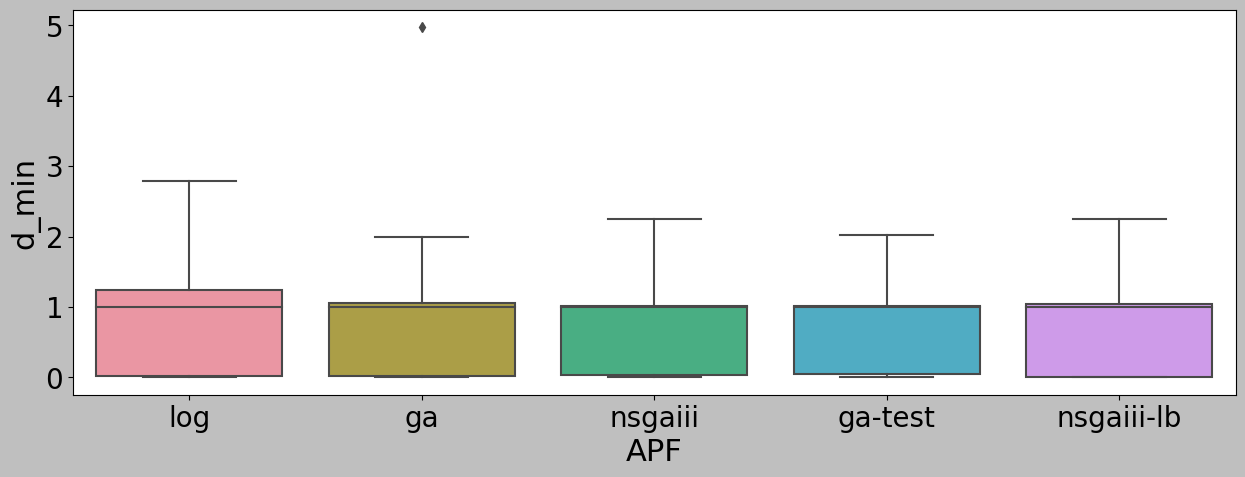

In [17]:
fname = 'Rastrigin'
tmp = df.query('target==@fname').drop(columns=['target'])
_ = sns.boxplot(x='APF', y='d_min', data=tmp)

In [18]:
from scipy.stats import ttest_ind

baseline_category = 'log'
baseline_values = tmp[tmp['APF'] == baseline_category]['min_score']

results = {}

# Perform the t-test for each category against the baseline
for category in tmp['APF'].unique():
    if category != baseline_category:
        category_values = tmp.query('APF==@category')['min_score']
        statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
        results[category] = {'statistic': statistic, 'p_value': p_value}

# Create a DataFrame to display the results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.name = 'Category'

# Display the results DataFrame
print(results_df.sort_values('p_value'))

            statistic   p_value
Category                       
nsgaiii-lb  -1.750380  0.042670
ga-test     -1.473324  0.073035
nsgaiii     -0.954975  0.171777
ga          -0.853728  0.198384


For each function, keep the best p and 0.

In [19]:
results = list()

for target in df.target.unique():
    tmp = df.query('target==@target')
    baseline_values = tmp.query('APF=="log"')['d_min']
    
    r = {'target':target}
    for apf in tmp.APF.unique():
        if apf != 'log':
            category_values = tmp.query('APF==@apf')['d_min']
            statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
            r[f'p_value_{apf}'] = p_value
    results.append(r)

results = pd.DataFrame(results).set_index('target')
results

C:\Users\dinus\AppData\Local\Temp\ipykernel_20520\1558855087.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')


,p_value_ga,p_value_ga-test,p_value_nsgaiii,p_value_nsgaiii-lb
target,,,,
Sphere,0.839768,0.500000,NaN,NaN
Bohachevsky,0.825152,NaN,NaN,NaN
Rosenbrock,0.093212,0.244944,0.745215,0.649211
Rastrigin,0.198384,0.073035,0.171777,0.042670
Ackley,0.947993,NaN,NaN,NaN
Griewangk,0.319587,0.396365,0.513563,0.025863
Schwefel,0.231432,0.027864,0.151564,0.028534
Eggholder,0.096220,NaN,0.005807,0.056188
Rana,0.037202,0.000680,0.036817,0.001167


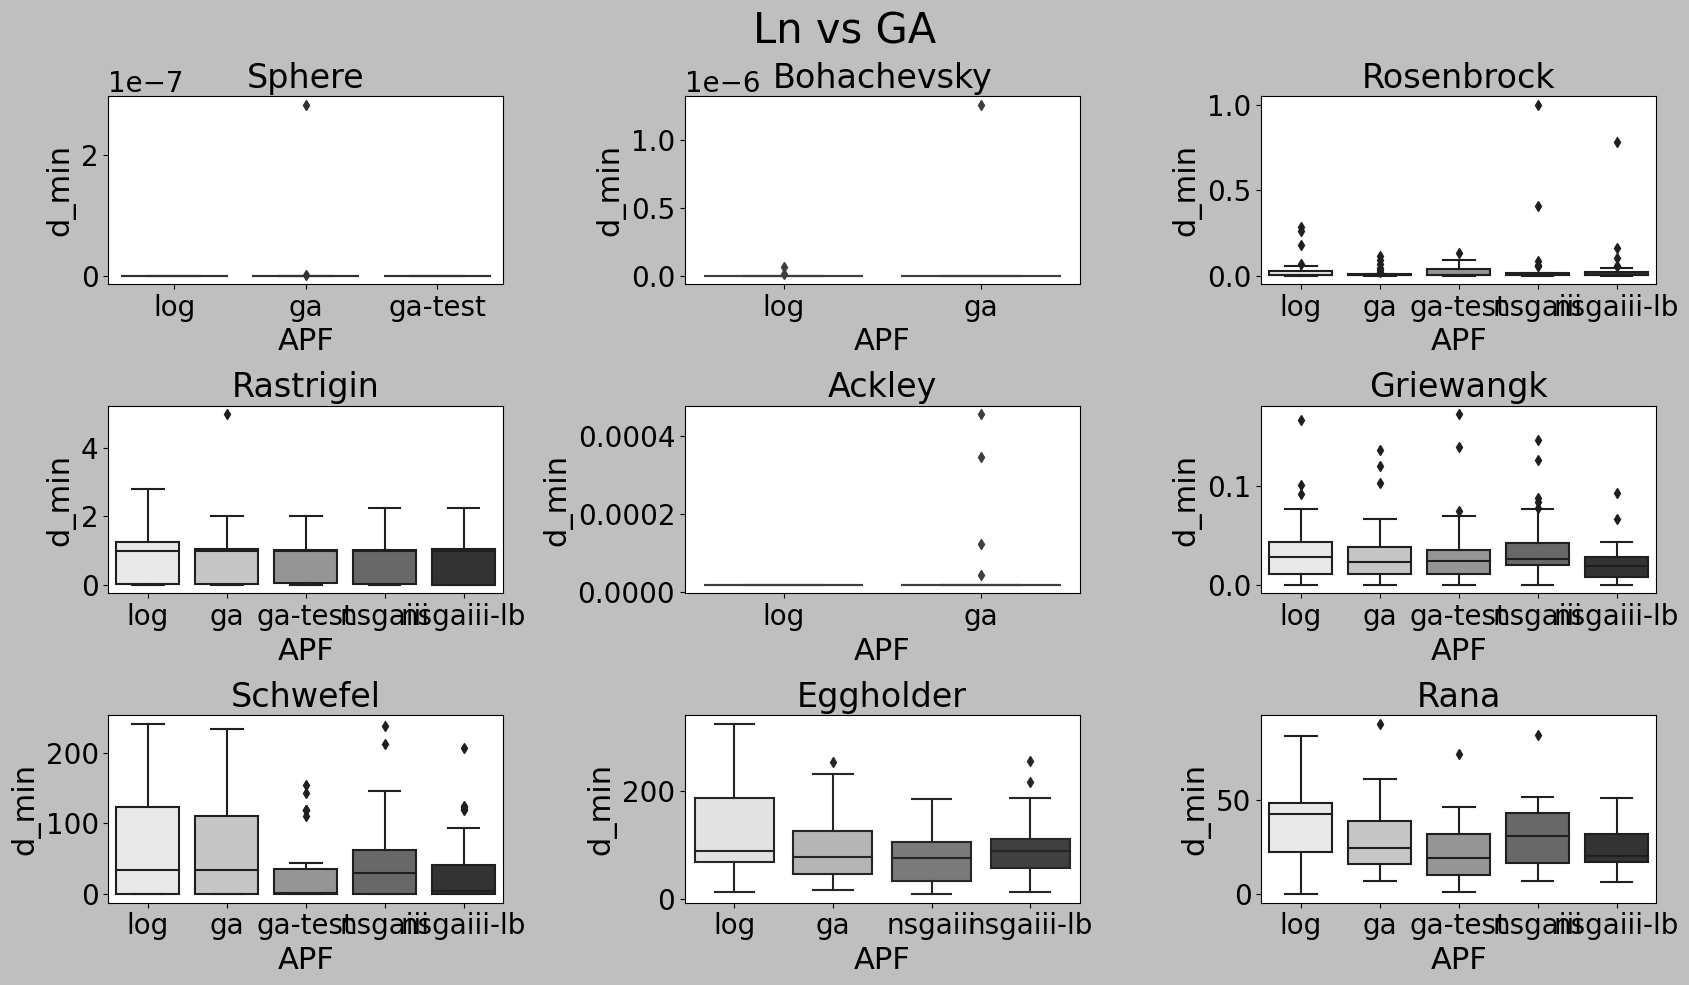

In [20]:
p = results['p_value_ga'].to_dict()

fig, ax = plt.subplots(3, 3, figsize=figsize33)
_ = plt.suptitle('Ln vs GA', fontsize=title_fontsize)
for i, target in enumerate(functions):
    _df = df[df.target==target.name].sort_values('APF', ascending=True)
    this_ax = ax[i // 3, i % 3]
    order = ['log', 'ga']
    for c in ['ga-test', 'nsgaiii', 'nsgaiii-lb']:
        if c in _df.APF.unique():
            order.append(c)
    _ = sns.boxplot(x='APF', y='d_min', data=_df, ax=this_ax, palette=('Greys'), order=order)
    _ = this_ax.set_title(f'{target.name}'); #  (p={round(p[target.name], 3)})
#         _ = this_ax.set_xticklabels(ap_names)
    _ = this_ax.set_xlabel('APF');
    _ = this_ax.set_ylabel('d_min');

fig.tight_layout()
_ = fig.savefig(plots_folder / 'Best_APFs_vs_monotonic_ln.png')

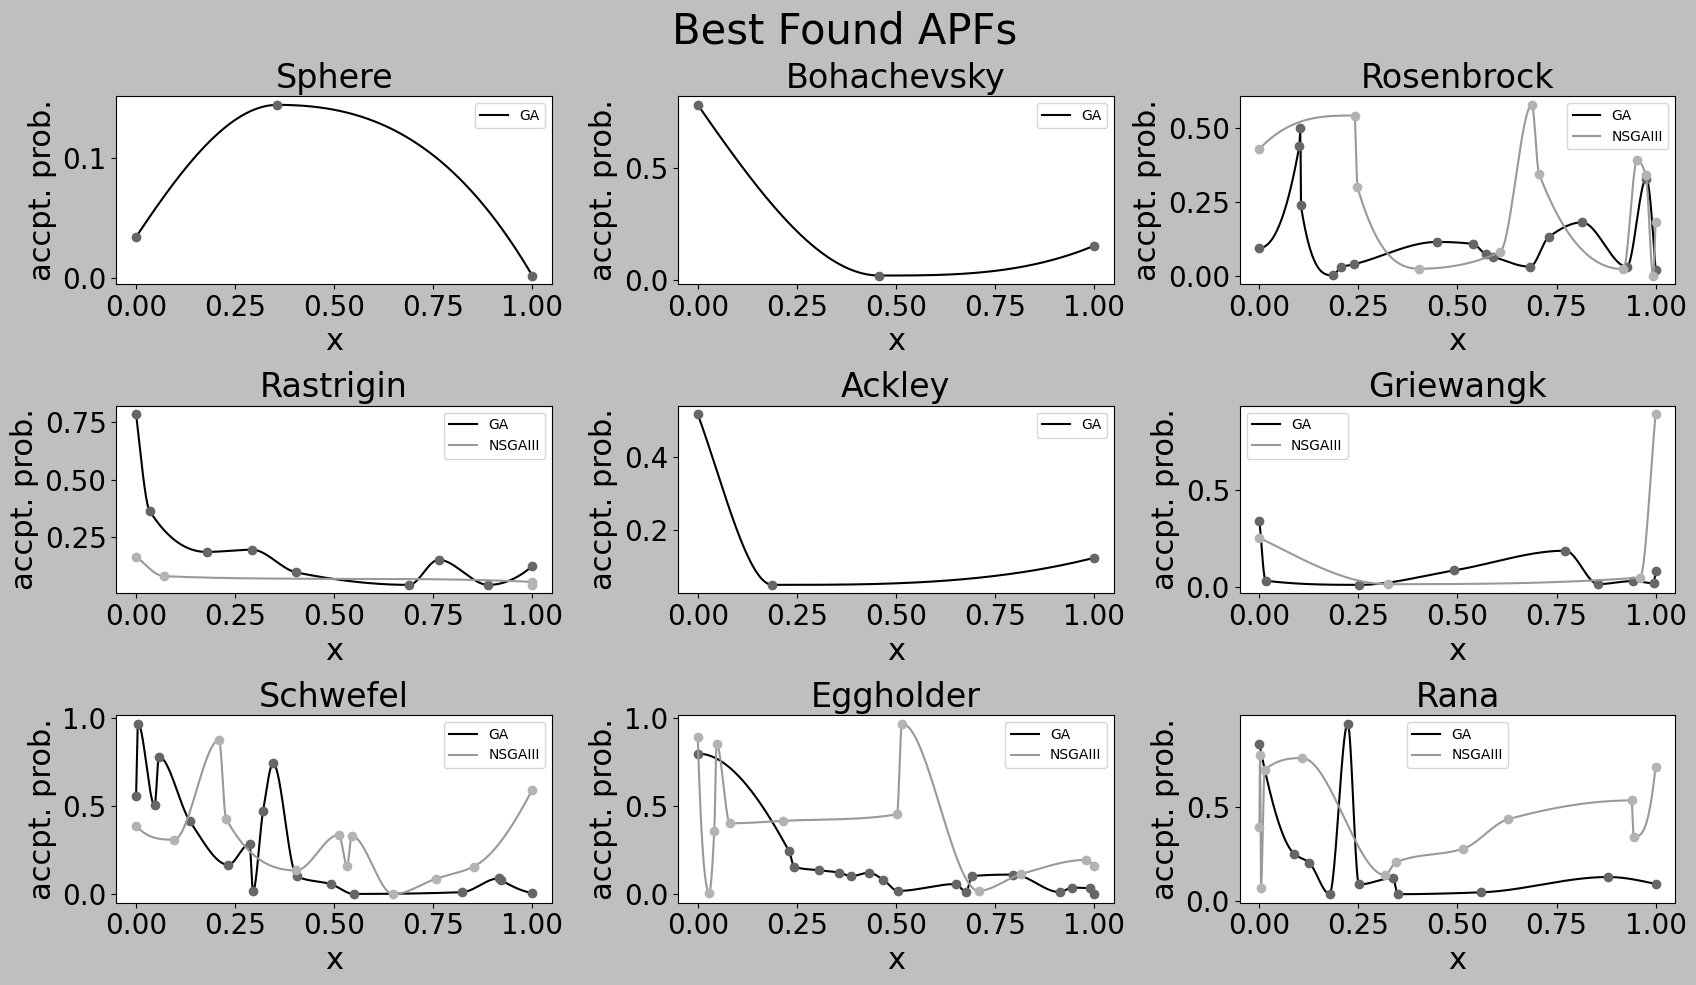

In [34]:
fig, ax = plt.subplots(3, 3, figsize=figsize33)
_ = plt.suptitle('Best Found APFs', fontsize=title_fontsize)

for i, target in enumerate(functions):
    this_ax = ax[i // 3, i % 3]
    
    x, y = ga_best_pts[target.name]
    xs, ys = ind_to_clean_points((x, y))
    newx, newy = dense_from_ind((x, y))
    _ = this_ax.plot(newx, newy, '-', label='GA')
    _ = this_ax.plot(xs, ys, 'o')
    
    try:
        x, y = nsga_ub_best_pts[target.name]
        xs, ys = ind_to_clean_points((x, y))
        newx, newy = dense_from_ind((x, y))
        _ = this_ax.plot(newx, newy, '-', label='NSGAIII')
        _ = this_ax.plot(xs, ys, 'o')
    except Exception as e:
        pass
    
    _ = this_ax.set_title(f'{target.name}'); #  (pts={len(x)}+2)
    _ = this_ax.set_xlabel('x');
    _ = this_ax.set_ylabel('accpt. prob.');
    _ = this_ax.legend()
    
fig.tight_layout()
_ = fig.savefig(plots_folder / 'Best_APFs_found.png')